NOTE: regressions are not finished

In [38]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plotnine import *
import sys
from patsy import dmatrices
import warnings

warnings.filterwarnings("ignore")

In [2]:
path = Path(os.getcwd())

base_dir = path.parent.parent

data_in = os.path.join(str(base_dir) , "da_data_repo/arizona-electricity/raw/")
data_out = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/")
output = os.path.join(str(base_dir), "da_case_studies/ch12-electrictiy-temperature/output/")
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

sys.path.append(func)

In [3]:
from py_helper_functions import *

In [4]:
electricity = pd.read_csv(os.path.join(data_in,"electricity_resid_AZ.csv"))

In [5]:
electricity.head()

,MY,Q
0,Jan-01,2063
1,Feb-01,1790
2,Mar-01,1690
3,Apr-01,1404
4,May-01,1984


In [6]:
electricity['date']=pd.to_datetime(electricity['MY'],format='%b-%y')

In [7]:
electricity['year'] = electricity['date'].dt.year
electricity['month'] = electricity['date'].dt.month
electricity['ym']=electricity['year'].astype(str).str.cat(electricity['month'].astype(str),sep='m')

In [8]:
electricity.head()

,MY,Q,date,year,month,ym
0,Jan-01,2063,2001-01-01,2001,1,2001m1
1,Feb-01,1790,2001-02-01,2001,2,2001m2
2,Mar-01,1690,2001-03-01,2001,3,2001m3
3,Apr-01,1404,2001-04-01,2001,4,2001m4
4,May-01,1984,2001-05-01,2001,5,2001m5


In [9]:
electricity = electricity[['Q','date','ym']]

In [10]:
electricity['lnQ']=electricity['Q'].map(np.log)

In [11]:
electricity['lnQ']

0      7.631917
1      7.489971
2      7.432484
3      7.247081
4      7.592870
         ...   
202    7.564757
203    7.695303
204    7.682482
205    7.548029
206    7.592366
Name: lnQ, Length: 207, dtype: float64

In [12]:
climate = pd.read_csv(os.path.join(data_in,"climate_Phoenix_AZ.csv"))

In [13]:
climate['tempdate']=pd.to_datetime(climate['DATE'],format='%Y-%m')

In [14]:
climate['year'] = climate['tempdate'].dt.year
climate['month'] = climate['tempdate'].dt.month
climate['ym']=climate['year'].astype(str).str.cat(climate['month'].astype(str),sep='m')

In [15]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1


In [16]:
climate['ndays']=30
climate.loc[climate['month'].isin([1, 3, 5, 7, 8, 10, 12]),'ndays']=31
climate.loc[climate['month']==2,'ndays']=28

In [17]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym,ndays
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9,30
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10,31
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11,30
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12,31
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1,31


In [18]:
for x in ["CLDD", "HTDD", "DX70", "DX90"]:
    climate[x +'_avg']=climate[x]/climate['ndays']

In [19]:
climate.head()

,STATION,NAME,DATE,CLDD,DX32,DX70,DX90,HTDD,tempdate,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,USW00023183,"PHOENIX AIRPORT, AZ US",1990-09,676,0,30,28,0,1990-09-01,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,USW00023183,"PHOENIX AIRPORT, AZ US",1990-10,425,0,31,24,0,1990-10-01,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,USW00023183,"PHOENIX AIRPORT, AZ US",1990-11,98,0,26,0,70,1990-11-01,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,USW00023183,"PHOENIX AIRPORT, AZ US",1990-12,0,0,14,0,353,1990-12-01,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,USW00023183,"PHOENIX AIRPORT, AZ US",1991-01,0,0,6,0,283,1991-01-01,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [20]:
climate[["CLDD_avg", "HTDD_avg", "DX70_avg", "DX90_avg"]].describe()

,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
count,332.000000,332.000000,332.000000,332.000000
mean,12.698136,2.422917,0.822810,0.468293
std,11.576086,3.525208,0.257170,0.431420
min,0.000000,0.000000,0.107143,0.000000
25%,0.666667,0.000000,0.694643,0.000000
50%,10.163441,0.131183,1.000000,0.393548
75%,24.900000,4.120680,1.000000,0.967742
max,33.290323,12.129032,1.000000,1.000000


In [21]:
climate = climate.drop(columns=["DATE", "tempdate", "STATION", "NAME"])

In [22]:
climate.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg
0,676,0,30,28,0,1990,9,1990m9,30,22.533333,0.000000,1.000000,0.933333
1,425,0,31,24,0,1990,10,1990m10,31,13.709677,0.000000,1.000000,0.774194
2,98,0,26,0,70,1990,11,1990m11,30,3.266667,2.333333,0.866667,0.000000
3,0,0,14,0,353,1990,12,1990m12,31,0.000000,11.387097,0.451613,0.000000
4,0,0,6,0,283,1991,1,1991m1,31,0.000000,9.129032,0.193548,0.000000


In [23]:
data = pd.merge(climate,electricity,on='ym',how='inner')

In [24]:
data = data[(data['year']>=2001) & (data['year']<=2017)].reset_index(drop=True)

In [25]:
data.loc[data['Q'].notnull(),['year','month']].describe()

,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [26]:
data.loc[data['CLDD'].notnull(),['year','month']].describe()

,year,month
count,204.000000,204.000000
mean,2009.000000,6.500000
std,4.911031,3.460545
min,2001.000000,1.000000
25%,2005.000000,3.750000
50%,2009.000000,6.500000
75%,2013.000000,9.250000
max,2017.000000,12.000000


In [27]:
data[["Q","lnQ","CLDD_avg","HTDD_avg"]].describe()

,Q,lnQ,CLDD_avg,HTDD_avg
count,204.000000,204.000000,204.000000,204.000000
mean,2636.392157,7.827744,13.317995,2.283919
std,864.697489,0.309525,11.779998,3.499287
min,1404.000000,7.247081,0.000000,0.000000
25%,1938.250000,7.569541,1.104551,0.000000
50%,2338.500000,7.757263,10.333333,0.016667
75%,3309.750000,8.104615,25.875000,3.737500
max,4674.000000,8.449771,33.290323,12.096774


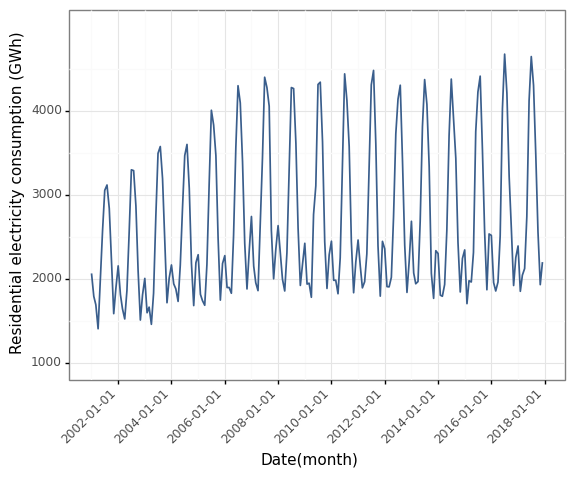

<ggplot: (326878169)>

In [31]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'Q'), colour=color[0],  size=0.7) 
 + labs(x = "Date(month)",y = "Residential electricity consumption (GWh)")
 + scale_y_continuous(limits = [1000,5000], breaks = seq(1000,5000,1000))
 + theme_bw()
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

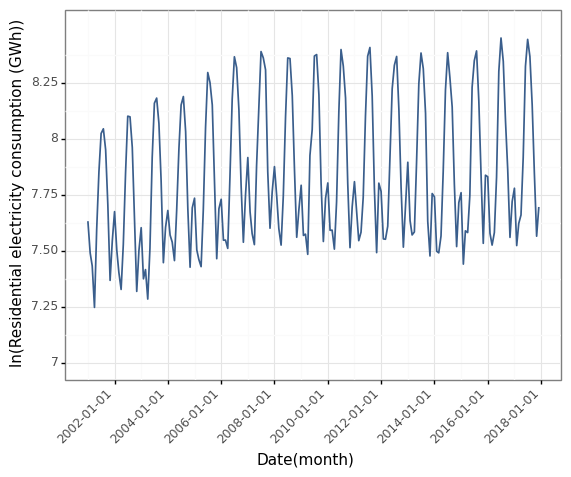

<ggplot: (326981027)>

In [32]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'lnQ'), colour=color[0],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(limits = [7,8.5], breaks = seq(7,8.5,0.25))
 + theme_bw() 
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

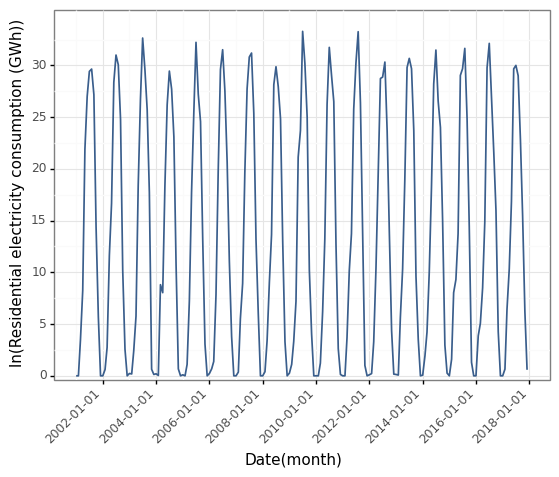

<ggplot: (326702123)>

In [33]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'CLDD_avg'), colour=color[0],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(expand = [0.01,0.01],limits = [0,35], breaks = seq(0,35,5)) 
 + theme_bw() 
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

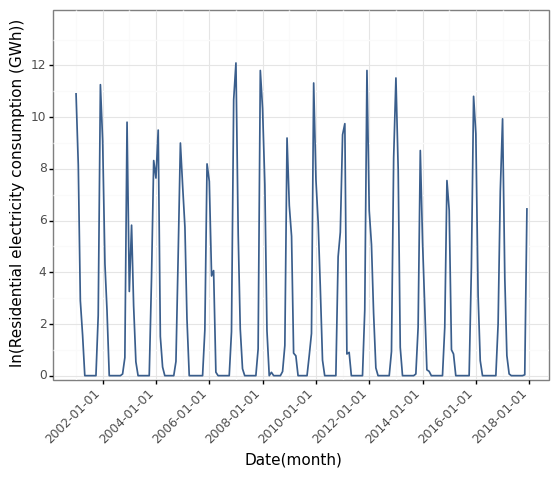

<ggplot: (287430039)>

In [34]:
g1 = (ggplot(data = data) 
 + geom_line(aes(x = 'date', y = 'HTDD_avg'), colour=color[0],  size=0.7) 
 + labs(x = "Date(month)",y = "ln(Residential electricity consumption (GWh))")
 + scale_y_continuous(expand = [0.01,0.01],limits = [0,14], breaks = seq(0,14,2))
 + theme_bw() 
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
g1

In [35]:
#Serial correlation

In [36]:
for x in ["lnQ","CLDD_avg", "HTDD_avg", "DX90_avg"]:
    data['D'+x]=data[x]-data[x].shift()

In [37]:
data.head()

,CLDD,DX32,DX70,DX90,HTDD,year,month,ym,ndays,CLDD_avg,HTDD_avg,DX70_avg,DX90_avg,Q,date,lnQ,DlnQ,DCLDD_avg,DHTDD_avg,DDX90_avg
0,0,0,11,0,339,2001,1,2001m1,31,0.000000,10.935484,0.354839,0.000000,2063,2001-01-01,7.631917,NaN,NaN,NaN,NaN
1,0,0,11,0,228,2001,2,2001m2,28,0.000000,8.142857,0.392857,0.000000,1790,2001-02-01,7.489971,-0.141946,0.000000,-2.792627,0.000000
2,108,0,23,2,90,2001,3,2001m3,31,3.483871,2.903226,0.741935,0.064516,1690,2001-03-01,7.432484,-0.057487,3.483871,-5.239631,0.064516
3,247,0,27,11,47,2001,4,2001m4,30,8.233333,1.566667,0.900000,0.366667,1404,2001-04-01,7.247081,-0.185403,4.749462,-1.336559,0.302151
4,679,0,31,27,0,2001,5,2001m5,31,21.903226,0.000000,1.000000,0.870968,1984,2001-05-01,7.592870,0.345790,13.669892,-1.566667,0.504301


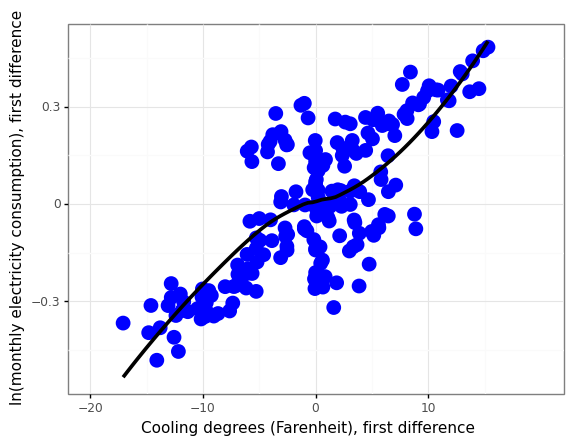

<ggplot: (326901044)>

In [39]:
(
    ggplot(data=data)
    + geom_point(
        aes(x="DCLDD_avg", y="DlnQ"), size=2, stroke=2, fill="blue", color="blue"
    )
    + geom_smooth(
        aes(x="DCLDD_avg", y="DlnQ"),
        method="loess",
        se=False,
        colour="black",
        size=1.5,
        span=0.9,
    )
    + labs(
        x="Cooling degrees (Farenheit), first difference",
        y="ln(monthly electricity consumption), first difference",
    )
    + scale_x_continuous(limits=[-20, 20], breaks=seq(-20, 20, 10))
    + theme_bw()
)

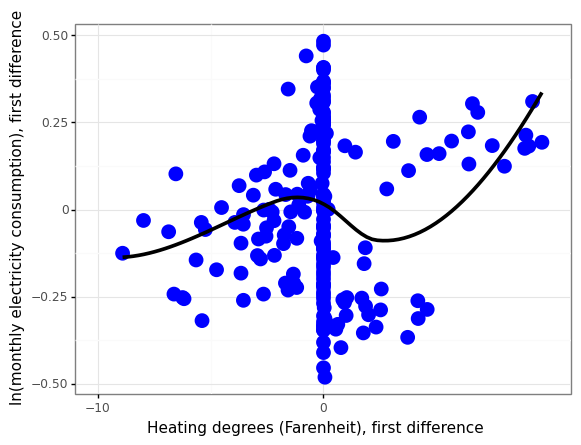

<ggplot: (326964694)>

In [40]:
(ggplot(data = data) 
 + geom_point(aes(x = 'DHTDD_avg', y = 'DlnQ'),size=2, stroke=2, fill="blue", color="blue") 
 + geom_smooth(aes(x = 'DHTDD_avg', y = 'DlnQ'),method="loess", se=False, colour="black", size=1.5, span=0.9)
 + labs(x = "Heating degrees (Farenheit), first difference",y = "ln(monthly electricity consumption), first difference") 
 + scale_x_continuous(limits = [-10,10], breaks = seq(-10,10, 10))
 + theme_bw() 
)

In [41]:
#Linear regressions

In [42]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg",data)

In [43]:
reg1 = sm.OLS(y, X).fit()
reg_results = reg1.get_robustcov_results(cov_type='HAC',maxlags=18)

In [44]:
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1114.
Date:                Wed, 05 May 2021   Prob (F-statistic):          3.65e-109
Time:                        15:00:42   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.477      0.634      -0.003       0.005
DCLDD_avg      0.0307      0.001     33.658      0.000       0.029       0.032
DHTDD_avg      0.0367      0.003     10.609      0.000       0.030       0.044
==============================================================================
Omnibus:                        4.221   Durbin-Watson:                   2.547
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.632
Skew:                          -0.164   Prob(JB):                       0.0986
Kurtosis:                       3.664   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [45]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month)",data)

In [46]:
reg4 = sm.OLS(y, X).fit()

In [47]:
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     281.4
Date:                Wed, 05 May 2021   Prob (F-statistic):          4.99e-116
Time:                        15:00:45   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      6.957      0.000       0.066       0.118
C(month)[T.2]     -0.2740      0.018    -15.022      0.000      -0.310      -0.238
C(month)[T.3]     -0.1219      0.019     -6.314      0.000      -0.160      -0.084
C(month)[T.4]     -0.1837      0.019     -9.480      0.000      -0.222      -0.145
C(month)[T.5]      0.0327      0.023      1.418      0.158      -0.013       0.078
C(month)[T.6]      0.0807      0.025      3.244      0.001       0.032       0.130
C(month)[T.7]      0.0580      0.019      3.046      0.003       0.020       0.096
C(month)[T.8]     -0.0854      0.018     -4.673      0.000      -0.121      -0.049
C(month)[T.9]     -0.1757      0.020     -8.985      0.000      -0.214      -0.137
C(month)[T.10]    -0.2464      0.025     -9.806      0.000      -0.296      -0.197
C(month)[T.11]    -0.2418      0.024    -10.004      0.000      -0.289      -0.194
C(month)[T.12]     0.0672      0.026      2.561      0.011       0.015       0.119
DCLDD_avg          0.0169      0.002     10.509      0.000       0.014       0.020
DHTDD_avg          0.0140      0.002      5.902      0.000       0.009       0.019
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
reg4.get_robustcov_results(cov_type='HAC',maxlags=18).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     2310.
Date:                Wed, 05 May 2021   Prob (F-statistic):          1.64e-200
Time:                        15:00:45   Log-Likelihood:                 321.40
No. Observations:                 203   AIC:                            -614.8
Df Residuals:                     189   BIC:                            -568.4
Df Model:                          13                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0919      0.013      7.115      0.000       0.066       0.117
C(month)[T.2]     -0.2740      0.018    -15.446      0.000      -0.309      -0.239
C(month)[T.3]     -0.1219      0.024     -5.009      0.000      -0.170      -0.074
C(month)[T.4]     -0.1837      0.029     -6.427      0.000      -0.240      -0.127
C(month)[T.5]      0.0327      0.013      2.598      0.010       0.008       0.057
C(month)[T.6]      0.0807      0.031      2.621      0.009       0.020       0.141
C(month)[T.7]      0.0580      0.014      4.164      0.000       0.031       0.086
C(month)[T.8]     -0.0854      0.015     -5.689      0.000      -0.115      -0.056
C(month)[T.9]     -0.1757      0.014    -12.491      0.000      -0.203      -0.148
C(month)[T.10]    -0.2464      0.029     -8.472      0.000      -0.304      -0.189
C(month)[T.11]    -0.2418      0.033     -7.424      0.000      -0.306      -0.178
C(month)[T.12]     0.0672      0.022      3.087      0.002       0.024       0.110
DCLDD_avg          0.0169      0.002      7.106      0.000       0.012       0.022
DHTDD_avg          0.0140      0.003      4.155      0.000       0.007       0.021
==============================================================================
Omnibus:                        0.278   Durbin-Watson:                   2.395
Prob(Omnibus):                  0.870   Jarque-Bera (JB):                0.428
Skew:                          -0.047   Prob(JB):                        0.808
Kurtosis:                       2.796   Cond. No.                         90.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [55]:
y,X = dmatrices("DlnQ ~ DCLDD_avg + DHTDD_avg + C(month) + DlnQ.shift(-1)",data)
reg6 = sm.OLS(y, X).fit()
reg6.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     275.8
Date:                Wed, 05 May 2021   Prob (F-statistic):          1.20e-116
Time:                        15:03:23   Log-Likelihood:                 325.71
No. Observations:                 202   AIC:                            -621.4
Df Residuals:                     187   BIC:                            -571.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0508      0.017      2.909      0.004       0.016       0.085
C(month)[T.2]     -0.2366      0.021    -11.377      0.000      -0.278      -0.196
C(month)[T.3]     -0.0834      0.022     -3.818      0.000      -0.126      -0.040
C(month)[T.4]     -0.0866      0.034     -2.567      0.011      -0.153      -0.020
C(month)[T.5]      0.1484      0.040      3.698      0.000       0.069       0.228
C(month)[T.6]      0.1705      0.035      4.820      0.000       0.101       0.240
C(month)[T.7]      0.0979      0.022      4.490      0.000       0.055       0.141
C(month)[T.8]     -0.0780      0.018     -4.348      0.000      -0.113      -0.043
C(month)[T.9]     -0.2053      0.021     -9.844      0.000      -0.246      -0.164
C(month)[T.10]    -0.2713      0.025    -10.642      0.000      -0.322      -0.221
C(month)[T.11]    -0.1709      0.031     -5.461      0.000      -0.233      -0.109
C(month)[T.12]     0.1197      0.030      4.034      0.000       0.061       0.178
DCLDD_avg          0.0160      0.002     10.060      0.000       0.013       0.019
DHTDD_avg          0.0142      0.002      6.158      0.000       0.010       0.019
DlnQ.shift(-1)    -0.1938      0.056     -3.462      0.001      -0.304      -0.083
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                1.800
Skew:                          -0.069   Prob(JB):                        0.407
Kurtosis:                       2.559   Cond. No.                         173.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
y, X = dmatrices(
    """DlnQ ~ DCLDD_avg + DCLDD_avg.shift(-1) +
                          DCLDD_avg.shift(-1) +
                          DHTDD_avg + 
                          DHTDD_avg.shift(-1) +
                          DHTDD_avg.shift(-1) +
                          C(month)""",
    data,
)
reg7 = sm.OLS(y, X).fit()
reg7.get_robustcov_results(cov_type="HAC", maxlags=18).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     2016.
Date:                Wed, 05 May 2021   Prob (F-statistic):          5.38e-197
Time:                        15:03:11   Log-Likelihood:                 322.69
No. Observations:                 202   AIC:                            -613.4
Df Residuals:                     186   BIC:                            -560.4
Df Model:                          15                                         
Covariance Type:                  HAC                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0940      0.011      8.469      0.000       0.072       0.116
C(month)[T.2]          -0.2612      0.017    -15.607      0.000      -0.294      -0.228
C(month)[T.3]          -0.0974      0.023     -4.219      0.000      -0.143      -0.052
C(month)[T.4]          -0.1379      0.024     -5.786      0.000      -0.185      -0.091
C(month)[T.5]           0.0949      0.030      3.120      0.002       0.035       0.155
C(month)[T.6]           0.1157      0.029      4.055      0.000       0.059       0.172
C(month)[T.7]           0.0560      0.016      3.597      0.000       0.025       0.087
C(month)[T.8]          -0.1126      0.021     -5.355      0.000      -0.154      -0.071
C(month)[T.9]          -0.2380      0.034     -7.034      0.000      -0.305      -0.171
C(month)[T.10]         -0.3169      0.037     -8.556      0.000      -0.390      -0.244
C(month)[T.11]         -0.2785      0.033     -8.494      0.000      -0.343      -0.214
C(month)[T.12]          0.0624      0.022      2.843      0.005       0.019       0.106
DCLDD_avg               0.0146      0.002      6.121      0.000       0.010       0.019
DCLDD_avg.shift(-1)    -0.0044      0.002     -2.069      0.040      -0.009      -0.000
DHTDD_avg               0.0136      0.003      3.918      0.000       0.007       0.020
DHTDD_avg.shift(-1)    -0.0001      0.001     -0.094      0.925      -0.003       0.003
==============================================================================
Omnibus:                        2.430   Durbin-Watson:                   2.356
Prob(Omnibus):                  0.297   Jarque-Bera (JB):                1.821
Skew:                           0.018   Prob(JB):                        0.402
Kurtosis:                       2.536   Cond. No.                         160.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

In [56]:
data["DDCLDD_avg"]=data['DCLDD_avg']-data['DCLDD_avg'].shift()
data["DDHTDD_avg"]=data['DHTDD_avg']-data['DHTDD_avg'].shift()

In [57]:
y,X = dmatrices("""DlnQ ~ DCLDD_avg.shift(-2) +
                          DHTDD_avg.shift(-2) + 
                          DDCLDD_avg + DDHTDD_avg + 
                          DDCLDD_avg.shift(-1) + DDHTDD_avg.shift(-1) + 
                          C(month)""",data)

In [58]:
reg8 = sm.OLS(y, X).fit()
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DlnQ   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     1114.
Date:                Wed, 05 May 2021   Prob (F-statistic):          3.65e-109
Time:                        15:04:01   Log-Likelihood:                 182.98
No. Observations:                 203   AIC:                            -360.0
Df Residuals:                     200   BIC:                            -350.0
Df Model:                           2                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.002      0.477      0.634      -0.003       0.005
DCLDD_avg      0.0307      0.001     33.658      0.000       0.029       0.032
DHTDD_avg      0.0367      0.003     10.609      0.000       0.030       0.044
==============================================================================
Omnibus:                        4.221   Durbin-Watson:                   2.547
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                4.632
Skew:                          -0.164   Prob(JB):                       0.0986
Kurtosis:                       3.664   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""